## Introduction

The purpose of this notebook it to train CNN models to perform a classification task on a Flower 102 dataset: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html. 

The project includes following steps:

*   downloading and extracting data
*   converting images to numpy arrays
*   data augmentation
*   building a CNN model from scratch
*   Transfer Learning and Fine Tuning


## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image

import tarfile
import urllib
import os

In [2]:
IMAGES_URL = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
SETID_URL = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'
LABELS_URL = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
IMG_DIR = "jpg"
BASE_DIR = "."

## Downloads

Download and Extract .tgz file with .jpgs

In [3]:
if not os.path.exists(IMG_DIR):
    print('Downloading and extracting. It will take ~ 1 min')
    tfile = urllib.request.urlopen(IMAGES_URL)
    with tarfile.open(fileobj=tfile, mode='r|gz') as trfile:
        trfile.extractall()

#### Plotting random images


In [4]:
len(os.listdir("jpg"))
os.listdir("jpg")[0]

'image_02853.jpg'

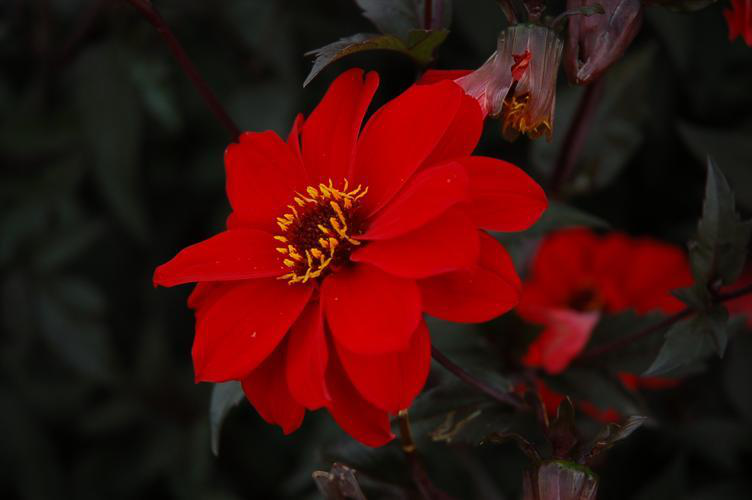

In [5]:
Image.open(os.path.join(IMG_DIR, os.listdir("jpg")[0]))

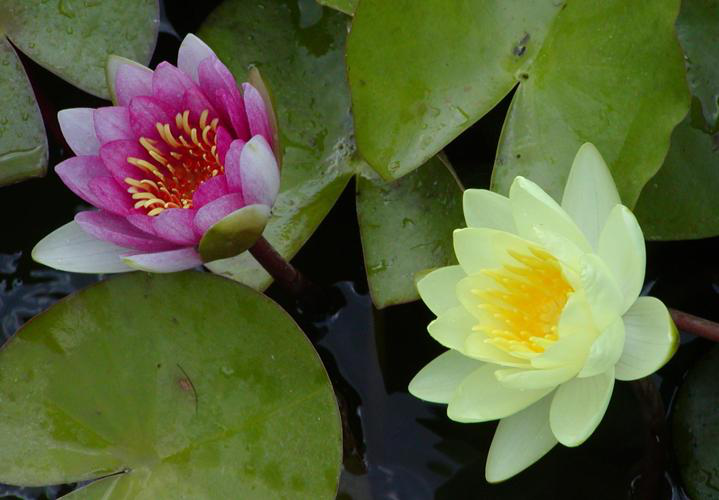

In [6]:
Image.open(os.path.join(IMG_DIR, os.listdir("jpg")[145]))

#### Downloading image labels and the indices that split the whole dataset

In [7]:
setid_file = 'setid.mat'
imagelabels_name = 'imagelabels.mat'
urllib.request.urlretrieve(SETID_URL, os.path.join(BASE_DIR, setid_file))
urllib.request.urlretrieve(LABELS_URL, os.path.join(BASE_DIR, imagelabels_name))
setid = scipy.io.loadmat(setid_file)
labels = scipy.io.loadmat(imagelabels_name)

`setid` contains 3 arrays that split indices for train, val and test datasets

In [8]:
setid

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16)}

In [9]:
max(setid['tstid'][0]), max(setid['trnid'][0]), max(setid['valid'][0])

(8189, 8177, 8187)

`lables.labels` contains the class numbers and is ordered just as indices hidden in filenames.

In [10]:
labels

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

## Data Preprocessing

Unique values for labels

In [11]:
np.unique(labels['labels'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102], dtype=uint8)

#### Extracting index from a filename function

All file names have the same length and look like this: `image_00853.jpg`. The index number can be extracted by slicing the same part of the string with filename.


In [12]:
def get_index(fname):
    "Slices the index number for a give filename and converts to int"
    idx_str = fname[6:11]
    return int(idx_str)

### Converting images to Numpy Array function

I need a function that takes each file as parameter and saves it in the dataset with the index equal to the number in .jpg file name

In [13]:
DATA_LEN = len(os.listdir(IMG_DIR))
IMG_W = 100
IMG_H = 100
CHANNELS = 3

dataset = np.zeros((DATA_LEN, IMG_W, IMG_H, CHANNELS))

def reshape_img(fname):
    "Reshapes and converts images to numpy array with values in range [0.0, 1.0]"
    # get image using pillow
    img = Image.open(os.path.join(IMG_DIR, fname))
    # resize image
    img = img.resize((IMG_W, IMG_H))
    # convert image to numpy array in range [0.0, 1.0]
    img = np.asarray(img) / 255.0
    return img 

def save_to_dataset(img):
    np_img = reshape_img(img)
    i = get_index(img)
    dataset[i-1, :, :, :] = np_img

### Calling Data Preprocessing functions

Converting and saving images to a numpy array called `dataset`. This step takes about 1 minute and I believe this can be improved

In [14]:
%%time
for f in os.listdir(IMG_DIR):
    save_to_dataset(f)

CPU times: user 1min 4s, sys: 455 ms, total: 1min 5s
Wall time: 1min 5s


In [15]:
dataset.shape

(8189, 100, 100, 3)

Getting the target values increased by one to get the range [0, 101]. This is necessary for the output Dense Layer

In [16]:
target = labels['labels'][0] - 1

In [17]:
np.max(target), np.min(target)

(101, 0)

In [18]:
setid['trnid'].shape, setid['tstid'].shape, setid['valid'].shape

((1, 1020), (1, 6149), (1, 1020))

I use permutation here, because there is no randomness in lables. They are already ordered. This means target[train_ids] looks like: [1, 1, 1, 1, ..., 2, 2, ..., 102, 102, 102]

`setid['tstid']` has over 6k indices, so we'll use it as the training dataset

In [19]:
np.random.seed(31)
train_ids = np.random.permutation(setid['tstid'][0])
val_ids = np.random.permutation(setid['valid'][0])
test_ids = np.random.permutation(setid['trnid'][0])

The range of values for setid is [1, 8189]. The range of indices for our dataset array is [0, 8188]. This is why I subtract 1 for each index. Otherwise there will be `IndexOutOfRange` Exception

In [20]:
x_train, y_train = dataset[train_ids - 1], target[train_ids - 1].flatten()
x_val, y_val = dataset[val_ids -1], target[val_ids -1].flatten()
x_test, y_test = dataset[test_ids -1], target[test_ids -1].flatten()

### Data Augmentation using `ImageDataGenerator`

In [21]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(height_shift_range=0.1, 
                             width_shift_range=0.1, 
                             horizontal_flip=True, 
                             zoom_range=0.1, 
                             rotation_range=20)

batch_size = 32
steps_per_epoch = x_train.shape[0] // batch_size

train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)

## Building the Image Classification Model from scratch

### Creating Layers and Initializing the Model

In [22]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.regularizers import l2

inp_shape = x_train[0].shape
classes = np.unique(target).shape[0]

i = Input(shape=inp_shape)
x = Conv2D(32, (5, 5), activation='relu')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(classes, activation='softmax')(x)

bmodel = Model(i, x)

The CNN Architucture I build consists of 6 Convolutional Layers in total. All of them are separated with a Batch Norm Layers working as regularizers. After every second conv layer there is a MaxPool layer to reduce the dimentionality and keep only the strongest features. 


In [23]:
# model.summary()

### Training the Model

In [24]:
bmodel.compile(
    tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', metrics=['accuracy'])

basic = bmodel.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
192/192 [==============================] - 22s 114ms/step - loss: 8.6538 - accuracy: 0.0647 - val_loss: 8.9794 - val_accuracy: 0.0225
Epoch 2/30
192/192 [==============================] - 21s 111ms/step - loss: 5.2416 - accuracy: 0.1010 - val_loss: 5.0860 - val_accuracy: 0.0667
Epoch 3/30
192/192 [==============================] - 21s 110ms/step - loss: 4.3722 - accuracy: 0.1306 - val_loss: 4.3648 - val_accuracy: 0.0863
Epoch 4/30
192/192 [==============================] - 21s 111ms/step - loss: 3.9973 - accuracy: 0.1476 - val_loss: 4.2776 - val_accuracy: 0.0902
Epoch 5/30
192/192 [==============================] - 21s 111ms/step - loss: 3.7570 - accuracy: 0.1666 - val_loss: 3.8761 - val_accuracy: 0.1618
Epoch 6/30
192/192 [==============================] - 21s 111ms/step - loss: 3.5466 - accuracy: 0.1834 - val_loss: 4.2629 - val_accuracy: 0.1216
Epoch 7/30
192/192 [==============================] - 21s 111ms/step - loss: 3.4354 - accuracy: 0.2035 - val_loss: 3.5468 - val_ac

### Learning Curves

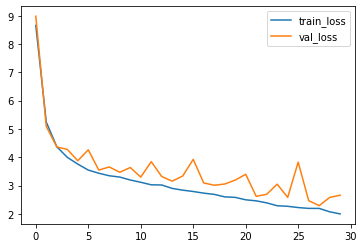

In [25]:
plt.plot(basic.history['loss'], label='train_loss')
plt.plot(basic.history['val_loss'], label='val_loss')
plt.legend();

### Evaluating on the test set

In [26]:
pred = bmodel.predict(x_test).argmax(axis=1)
bmodel.evaluate(x_test, y_test)

32/32 [==============================] - 1s 19ms/step - loss: 2.8506 - accuracy: 0.4078


[2.850595474243164, 0.40784314274787903]

The model was trained on a set of over 6k images, which is considered to be a small data set. 40% Accuracy on a completely new data after 30 epochs. This isn't bad at all if we consider, that random guessing would achieve Accuracy of ~1%. Looking at the Learning Curves I assume it could be possible to get some improvement if model kept training for some more epochs, since there is no clear overfitting yet.

## Transfer Learning using InceptionV3

Usually the best way to improve accuracy of a Deep Learning model is to gather more data and train it on a bigger dataset. Is there any solution if this isn't possible or is too expensive? Luckily, the answer is Yes. Using Convolutional Neural Networks it is possible to use very powerful models, that were trained Imagenet - a dataset containing millions of images with a 1000 classes. What is even better, with keras it is awfully easy to load those models. Let's use the one called Inception. 

### Importing model and weights

In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# this will download weights if needed
base_model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


### Applying new fully connected layers

In `base_model` there is an Inception model stored with its weights. However, as already mentioned, this model was trained for a different classification task. How to use it in this project? The good news is, all there is to do is to adjust the fully connected part of the model to prepare it for our task. I.e.  the convolutional part stays exactly how it was and get rid of the fully-connected part. To do it, I initialized the the Inception model with `include_top=False`. 

To train the model for the Flower Classification, the output layer must be the same as in the model that was built from scratch. The convolutional part will be completely reused and all the weights will be freezed with `layer.trainable=False` 

In [28]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)
# add an output layer to our 102 classes
preds = Dense(102, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# train only the layers that we just added, since they are randomly initialized
# in other words freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

r = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=(x_val, y_val))



Epoch 1/20
192/192 [==============================] - 24s 124ms/step - loss: 3.2130 - accuracy: 0.2746 - val_loss: 2.5107 - val_accuracy: 0.3922
Epoch 2/20
192/192 [==============================] - 21s 108ms/step - loss: 2.1769 - accuracy: 0.4545 - val_loss: 2.1648 - val_accuracy: 0.4588
Epoch 3/20
192/192 [==============================] - 21s 110ms/step - loss: 1.9070 - accuracy: 0.5114 - val_loss: 1.9972 - val_accuracy: 0.5088
Epoch 4/20
192/192 [==============================] - 21s 108ms/step - loss: 1.7182 - accuracy: 0.5442 - val_loss: 1.8788 - val_accuracy: 0.5333
Epoch 5/20
192/192 [==============================] - 21s 109ms/step - loss: 1.6416 - accuracy: 0.5691 - val_loss: 1.7510 - val_accuracy: 0.5627
Epoch 6/20
192/192 [==============================] - 21s 109ms/step - loss: 1.5316 - accuracy: 0.5861 - val_loss: 1.7564 - val_accuracy: 0.5441
Epoch 7/20
192/192 [==============================] - 21s 109ms/step - loss: 1.4746 - accuracy: 0.5987 - val_loss: 1.6879 - val_ac

We achieved 60% accuracy on a validation set after 20 epochs of training the weights from fully-connected layers. The convolutional part stayed exactly the same. What is quite remarkable, is that after only first 2 epochs this model already outperformed our model built from scratch! 

### Fine Tuning

At this point, the weights in the fully-connected part are well trained. The accuracy is already 20% better than in model built from scratch. And all of this without touching the convolutional part. So let's see what happens, when we unfreeze some of Convolutional Layers. The point is to create some feature maps that are better adjusted to our task. This method of improving performance is called Fine Tuning

In [36]:
# print all layers from base_model
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

Inception model consists of blocks. They are separated with layers called `mixed`. For Fine Tuning let's unfreeze the last 3 blocks to train them on our training data.

In [31]:
# the last 3 blocks begin at the 229th layer
# let's unfreeze them
for layer in model.layers[:229]:
   layer.trainable = False
for layer in model.layers[229:]:
   layer.trainable = True

# recompiling the model, so our changes take place
# using Adative Moment Estimation with a low learning ratee
model.compile(optimizer=Adam(lr=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the last 3 convolutional Layers along with fully connected ones
r = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
192/192 [==============================] - 25s 132ms/step - loss: 2.0403 - accuracy: 0.4850 - val_loss: 1.7278 - val_accuracy: 0.5529
Epoch 2/20
192/192 [==============================] - 24s 122ms/step - loss: 1.4115 - accuracy: 0.6162 - val_loss: 1.3832 - val_accuracy: 0.6255
Epoch 3/20
192/192 [==============================] - 23s 122ms/step - loss: 1.1815 - accuracy: 0.6753 - val_loss: 1.3672 - val_accuracy: 0.6500
Epoch 4/20
192/192 [==============================] - 23s 121ms/step - loss: 1.0243 - accuracy: 0.7208 - val_loss: 1.3555 - val_accuracy: 0.6716
Epoch 5/20
192/192 [==============================] - 23s 122ms/step - loss: 0.9231 - accuracy: 0.7335 - val_loss: 1.1325 - val_accuracy: 0.7127
Epoch 6/20
192/192 [==============================] - 23s 120ms/step - loss: 0.8397 - accuracy: 0.7602 - val_loss: 1.2273 - val_accuracy: 0.7078
Epoch 7/20
192/192 [==============================] - 23s 122ms/step - loss: 0.7639 - accuracy: 0.7773 - val_loss: 1.2134 - val_ac

### Learning curves

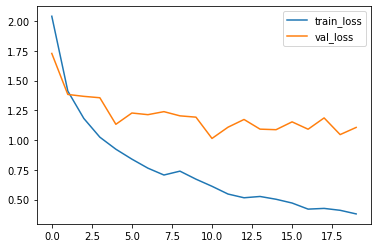

In [32]:
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

### Evaluating on the test set

In [33]:
pred = model.predict(x_test).argmax(axis=1)
model.evaluate(x_test, y_test)

32/32 [==============================] - 1s 46ms/step - loss: 1.2120 - accuracy: 0.7206


[1.2119746208190918, 0.720588207244873]

72% accuracy after 15 minutes of training in total. However, there is not too much improvement after 5th epoch and there is clearly overfitting. Transfer learning does work :)

## Summary

The goal behind creating this Notebook was to build CNN models that perform an Image Classification task on Flower 102 dataset. Two different models were trained: 

*   a model built from scratch and trained only on the train set used in this project
*   a model that applies Transfer Learning using Inception model trained on millions of images, but for a different classification task

After comparing the accuracy, it is clear that for this dataset the model that uses Transfer Learning can categorize much better and strongly outperforms the former model. Luckily, Keras API already has some pretrained, very powerful models that are ready to download. Building a model using Transfer Learning is just as easy as building one from scratch. 




